In [1]:
!git clone https://github.com/fizyr/keras-retinanet.git

Cloning into 'keras-retinanet'...
remote: Enumerating objects: 6220, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 6220 (delta 5), reused 6 (delta 2), pack-reused 6205
Receiving objects: 100% (6220/6220), 13.48 MiB | 25.85 MiB/s, done.
Resolving deltas: 100% (4205/4205), done.


In [2]:
%cd keras-retinanet/
!pip install .

/content/keras-retinanet
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/keras-retinanet
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for keras-retinanet: filename=keras_retinanet-1.0.0-cp38-cp38-linux_x86_64.whl size=172702 sha256=85096cde88c5a7fe718160d0e9714c0ff57bf7df1dbf9ee7e6521d5c5495a787
  Stored in directory: /root/.cache/pip/wheels/68/58/4e/8be58184393d8172c0cfc492d89ccfd890df58660b6308249f
  Created wheel for keras-resnet: filename=keras_resnet-0.2.0-py2.py3-none-any.whl size=20486 sha256=892f14fe9ff22009cad31f3ecd59d57af564fc6fd048615caef929e1b

In [3]:
!python setup.py build_ext --inplace

running build_ext
cythoning keras_retinanet/utils/compute_overlap.pyx to keras_retinanet/utils/compute_overlap.c
/usr/local/lib/python3.8/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/keras-retinanet/keras_retinanet/utils/compute_overlap.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'keras_retinanet.utils.compute_overlap' extension
creating build
creating build/temp.linux-x86_64-3.8
creating build/temp.linux-x86_64-3.8/keras_retinanet
creating build/temp.linux-x86_64-3.8/keras_retinanet/utils
x86_64-linux-gnu-gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -g -fwrapv -O2 -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/include/python3.8 -I/usr/local/lib/python3.8/dist-packages/numpy/core/include

In [ ]:
# !pip install keras==2.3.1
# !pip install tensorflow==2.1.0

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import requests
import urllib
import os
from PIL import Image

from keras_retinanet import models
from keras_retinanet.utils.image import preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption 
from keras_retinanet.utils.colors import label_color

In [5]:
# https://github.com/fizyr/keras-retinanet/releases
urllib.request.urlretrieve(
    'https://github.com/fizyr/keras-retinanet/releases/download/0.5.1/resnet50_coco_best_v2.1.0.h5',
    'pretrained_model.h5')

('pretrained_model.h5', <http.client.HTTPMessage at 0x7fec46385820>)

In [6]:
model = models.load_model('pretrained_model.h5')

In [7]:
!wget https://lazyprogrammer.me/course_files/obj_detection/coco_categories.txt

--2022-12-25 05:18:04--  https://lazyprogrammer.me/course_files/obj_detection/coco_categories.txt
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/plain]
Saving to: ‘coco_categories.txt’

coco_categories.txt     [ <=>                ]     621  --.-KB/s    in 0s      

2022-12-25 05:18:05 (73.6 MB/s) - ‘coco_categories.txt’ saved [621]



In [8]:
class_names = [l.rstrip() for l in open('coco_categories.txt')]
class_names

['person',
 'bicycle',
 'car',
 'motorcycle',
 'airplane',
 'bus',
 'train',
 'truck',
 'boat',
 'traffic light',
 'fire hydrant',
 'stop sign',
 'parking meter',
 'bench',
 'bird',
 'cat',
 'dog',
 'horse',
 'sheep',
 'cow',
 'elephant',
 'bear',
 'zebra',
 'giraffe',
 'backpack',
 'umbrella',
 'handbag',
 'tie',
 'suitcase',
 'frisbee',
 'skis',
 'snowboard',
 'sports ball',
 'kite',
 'baseball bat',
 'baseball glove',
 'skateboard',
 'surfboard',
 'tennis racket',
 'bottle',
 'wine glass',
 'cup',
 'fork',
 'knife',
 'spoon',
 'bowl',
 'banana',
 'apple',
 'sandwich',
 'orange',
 'broccoli',
 'carrot',
 'hot dog',
 'pizza',
 'donut',
 'cake',
 'chair',
 'couch',
 'potted plant',
 'bed',
 'dining table',
 'toilet',
 'tv',
 'laptop',
 'mouse',
 'remote',
 'keyboard',
 'cell phone',
 'microwave',
 'oven',
 'toaster',
 'sink',
 'refrigerator',
 'book',
 'clock',
 'vase',
 'scissors',
 'teddy bear',
 'hair drier',
 'toothbrush']

In [10]:
len(class_names)

80

In [21]:
def show_image_with_predictions(img_path, threshold=0.6):
  im = np.array(Image.open(img_path))
  print("im.shape:", im.shape)

  # if there's a PNG it will have alpha channel
  im = im[:,:,:3]
  
  ### plot predictions ###

  # get predictions
  imp = preprocess_image(im)
  imp, scale = resize_image(im)

  boxes, scores, labels = model.predict_on_batch(
    np.expand_dims(imp, axis=0)
  ) #1 single img

  # standardize box coordinates
  boxes /= scale

  # loop through each prediction for the input image
  for box, score, label in zip(boxes[0], scores[0], labels[0]):
    # scores are sorted so we can quit as soon
    # as we see a score below threshold
    if score < threshold:
      break

    box = box.astype(np.int32)
    color = label_color(label)
    draw_box(im, box, color=color)

    class_name = class_names[label]
    caption = f"{class_name} {score:.3f}"
    draw_caption(im, box, caption)

  plt.axis('off')
  plt.imshow(im)
  plt.show()


In [12]:
plt.rcParams['figure.figsize'] = [20, 10]

In [17]:
cd keras-retinanet/

/content/keras-retinanet


im.shape: (430, 638, 3)


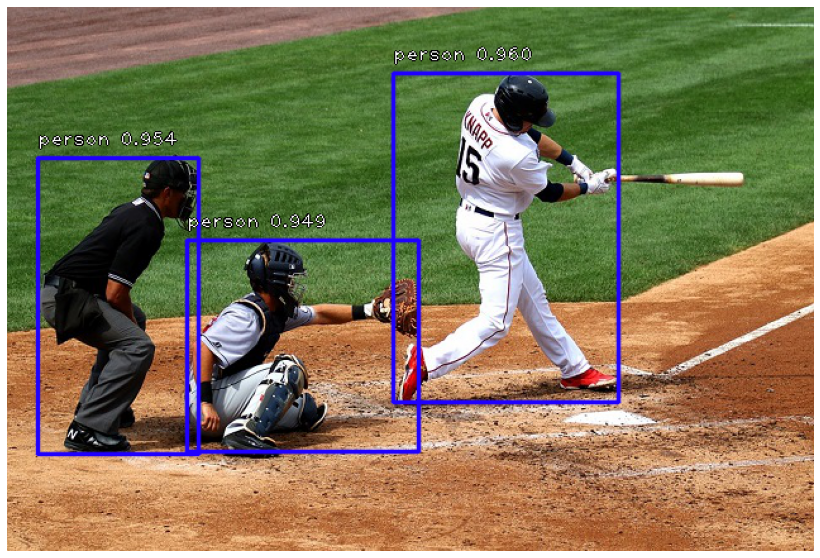

In [22]:
show_image_with_predictions('baseball.jpg', threshold=0.4)

im.shape: (666, 1000, 3)


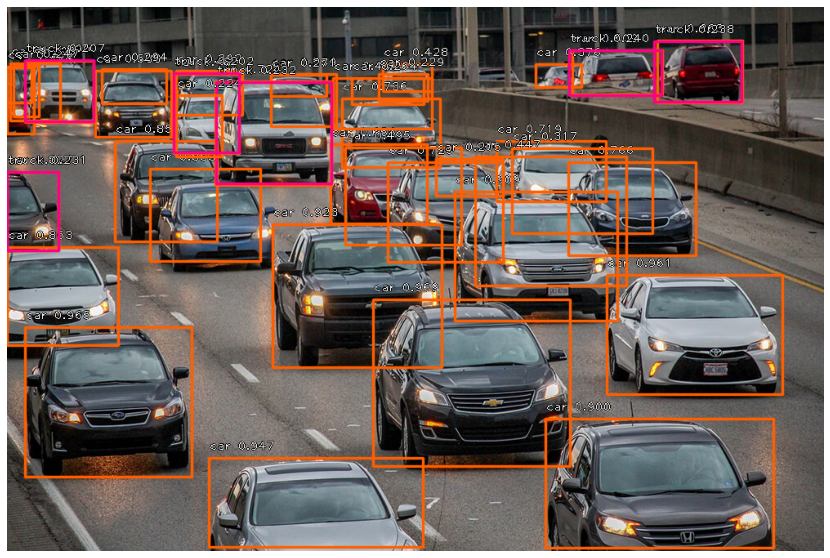

In [25]:
show_image_with_predictions('cars.jpg', threshold=0.2)

im.shape: (384, 512, 3)


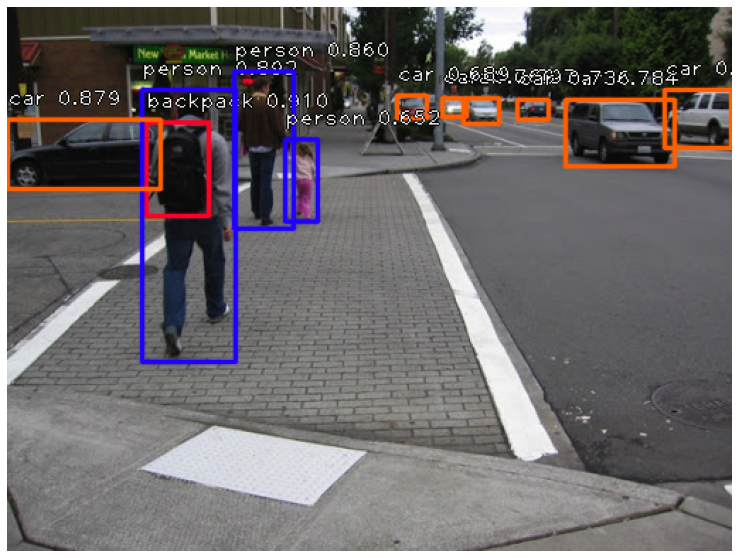

In [26]:
show_image_with_predictions('crosswalk.jpg')

--2022-12-24 03:16:30--  https://lazyprogrammer.me/course_files/obj_detection/laptop.jpg
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 233204 (228K) [image/jpeg]
Saving to: ‘laptop.jpg’

laptop.jpg          100%[===================>] 227.74K  --.-KB/s    in 0.1s    

2022-12-24 03:16:30 (2.21 MB/s) - ‘laptop.jpg’ saved [233204/233204]

im.shape: (618, 960, 3)


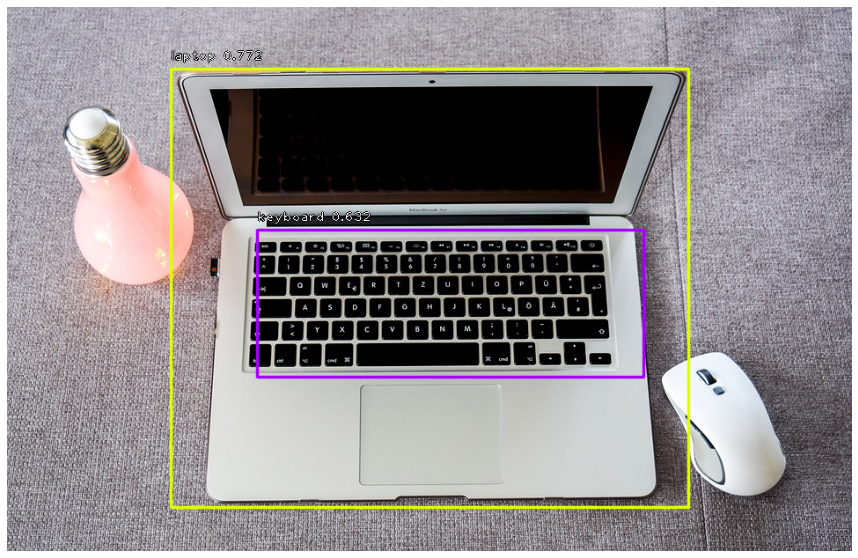

In [ ]:
show_image_with_predictions('laptop.jpg')